# Implementing Differentiable IIR in PyTorch

## Naive IIR Implementation

IIR is a linear system so it is differentiable everywhere. Let us first implement it in PyTorch using the above equation directly and see how it performs. 


In [180]:
import torch
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from torchaudio.functional import lfilter
from timeit import timeit
from torch.profiler import profile, record_function, ProfilerActivity

In [181]:
@torch.jit.script
def naive_iir(x: torch.Tensor, a: torch.Tensor):
    """
    Naive implementation of IIR filter.
    """
    assert x.ndim == 1
    assert a.ndim == 1
    T = x.numel()
    M = a.numel()

    # apply initial rest condition
    y = [x.new_zeros(1)] * M
    for i in range(T):
        past_outputs = torch.cat(y[-1:-M-1:-1])
        y.append(x[i:i+1] -torch.dot(a, past_outputs))
    return torch.cat(y[M:])

For simplicity, the above implementation assumes for $n < 0$, $y[n]$ are always zeros. In addition, I use `torch.jit.script` to utilise just-in-time compilation for speed improvement. Let us check whether the implementation is correct by comparing it with the `scipy.signal.lfilter` function.

The test signal is a chirp signal with a frequency that increases linearly from 1 Hz to 1000 Hz in 1 second. The sampling rate is 16000 Hz.

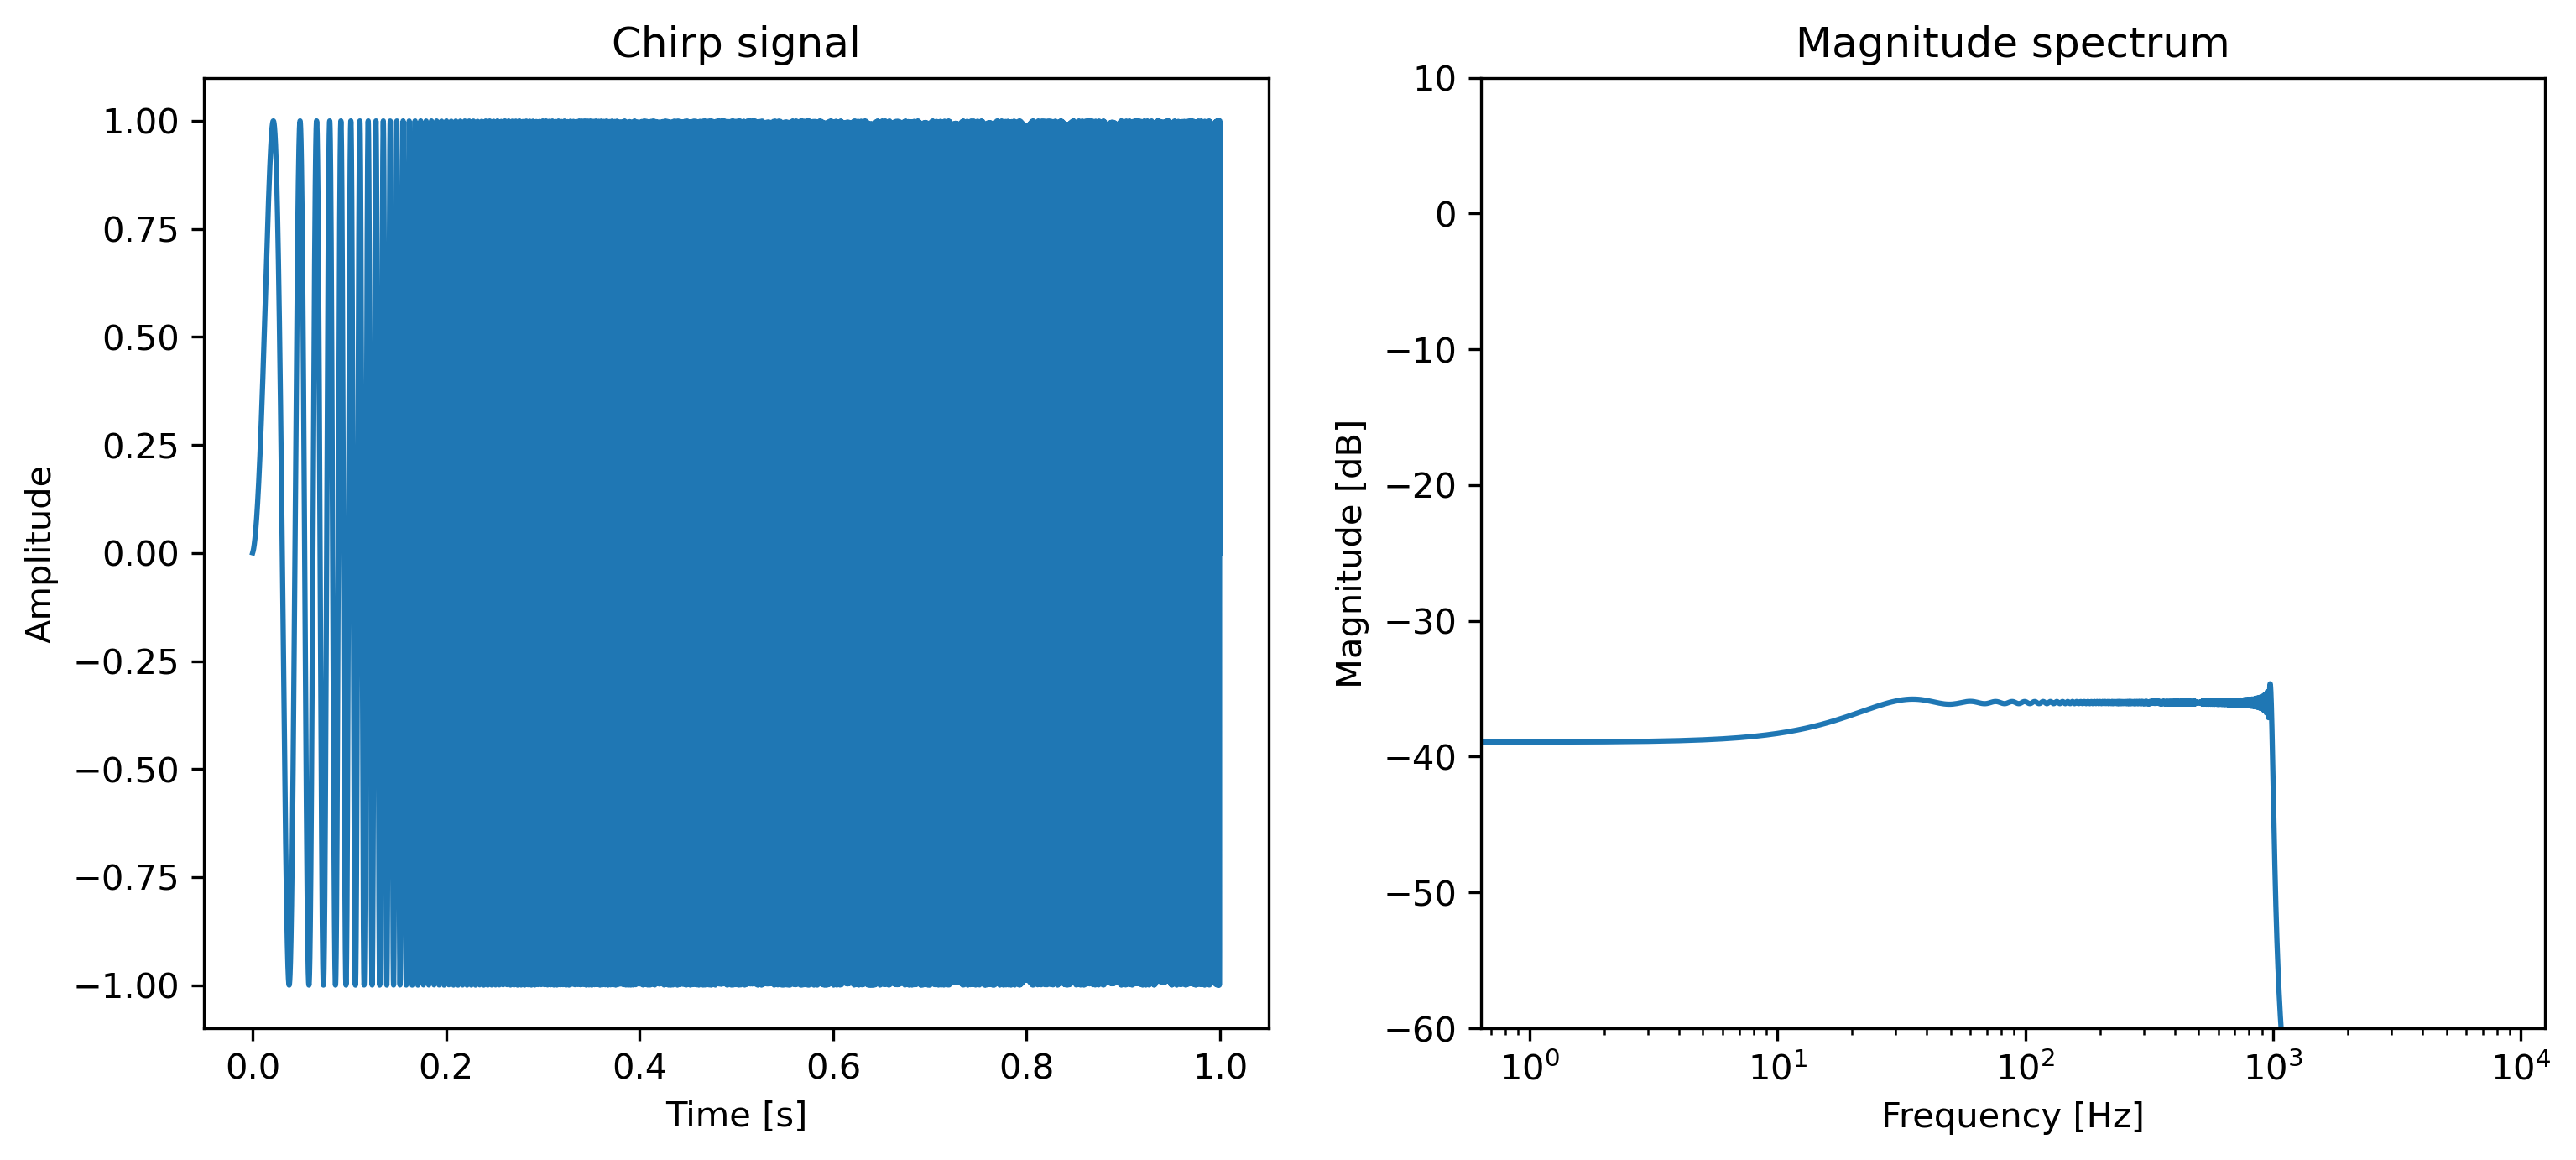

In [182]:
def chirp(T: int, start_freq: float, end_freq: float, fs: float):
    """
    Generate chirp signal.
    """
    angular_freq = np.linspace(start_freq, end_freq, T) / fs
    phase = np.cumsum(angular_freq)
    return np.sin(2 * np.pi * phase)

fs = 16000
T = 16000
start_freq = 1
end_freq = 1000
test_signal = chirp(T, start_freq, end_freq, fs)

fig = plt.figure(figsize=(12, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(np.arange(T) / fs, test_signal)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Chirp signal")
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(test_signal, Fs=fs, scale='dB', window=signal.windows.boxcar(T))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.xscale("log")
plt.ylim(-60, 10)
plt.title("Magnitude spectrum")
plt.show()

The filter we use is a second-order low pass IIR ($M$ = 2) with coefficients $a_1 = -1.8$ and $a_2 = 0.81$. Let us see how the filter performs on the chirp signal.

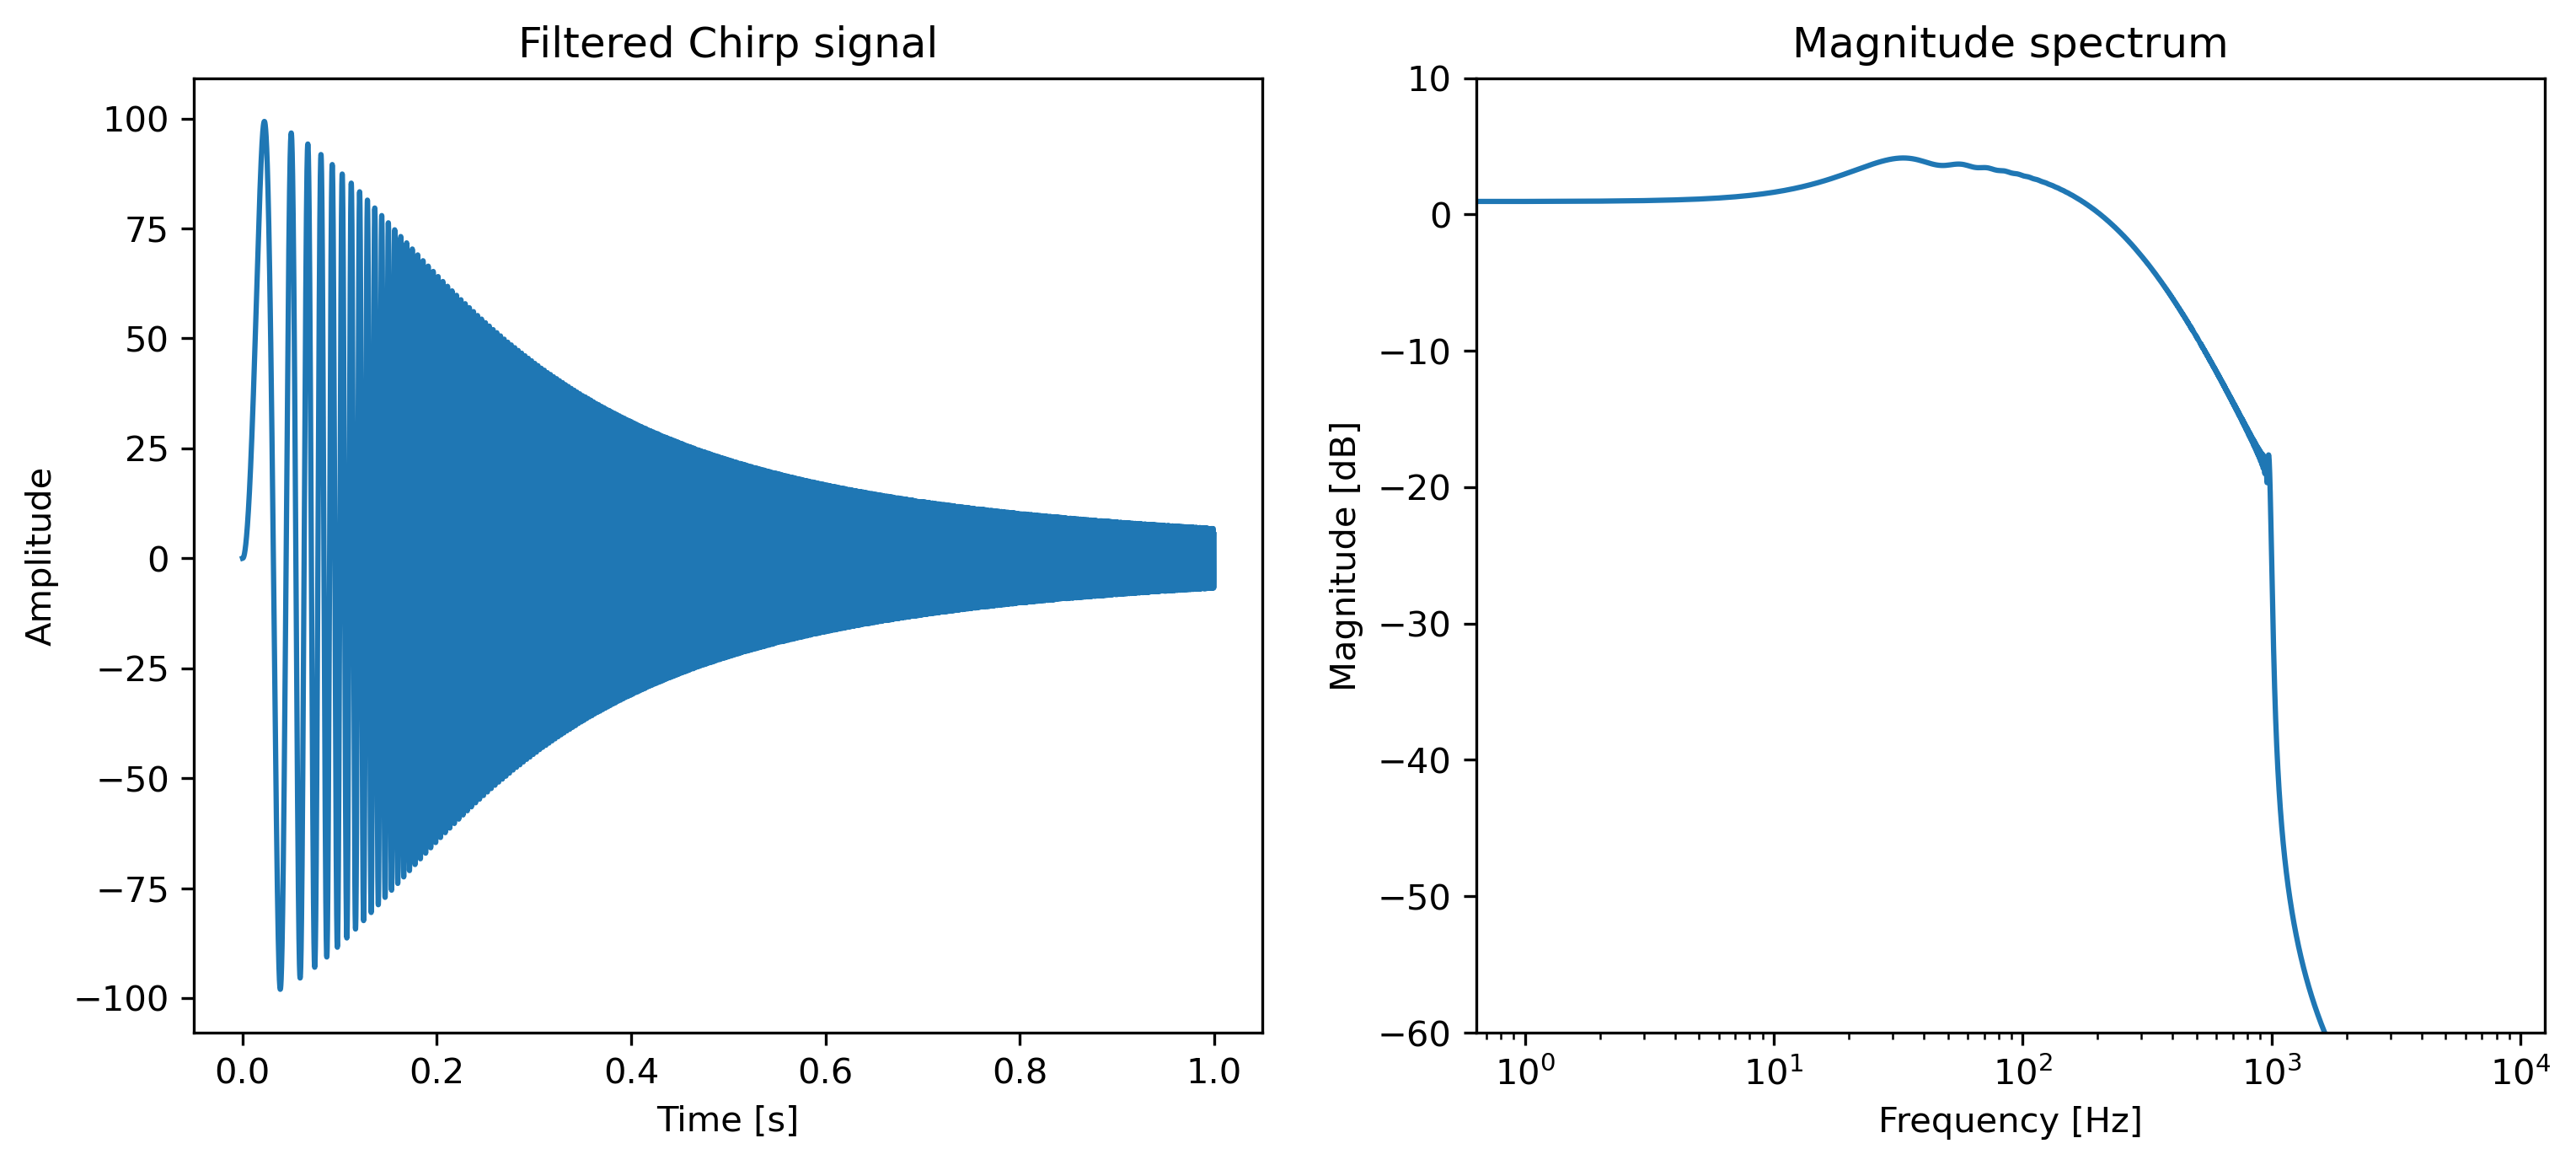

In [183]:
# b, a = signal.iirfilter(2, 50 / fs * 2, btype='lowpass', analog=False, ftype='butter', output='ba')
# print("b:", b)
# print("a:", a)
b = [1, 0]
a = [1, -0.9 * 2, 0.9 ** 2]
filtered_signal = signal.lfilter(b, a, test_signal)

fig = plt.figure(figsize=(12, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(np.arange(T) / fs, filtered_signal)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Filtered Chirp signal")
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(filtered_signal, Fs=fs, scale='dB', window=signal.windows.boxcar(T))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.xscale("log")
plt.ylim(-60, 10)
plt.title("Magnitude spectrum")
plt.show()

Is our PyTorch implementation correct? Let us compare it with the `scipy.signal.lfilter` function.

In [184]:
a_torch = torch.tensor(a[1:], dtype=torch.float64)
test_signal_torch = torch.tensor(test_signal, dtype=torch.float64)
filtered_signal_torch = naive_iir(test_signal_torch, a_torch)

torch.allclose(filtered_signal_torch, torch.from_numpy(filtered_signal))

True

Horay! It pass the test. Let us now see how fast it is.

In [194]:
scipy_time = timeit(
    stmt="signal.lfilter(b, a, test_signal)", setup="from scipy import signal", 
    globals={
        "b": b,
        "a": a,
        "test_signal": test_signal
    },
    number=1000
) / 1000

torch_time = timeit(
    stmt="naive_iir(test_signal_torch, a_torch)",
    globals={
        "a_torch": a_torch,
        "test_signal_torch": test_signal_torch,
        "naive_iir": naive_iir
    },
    number=10
) / 10

print(f"scipy.signal.lfilter: {scipy_time:.5f} [s]")
print(f"naive_iir: {torch_time:.4f} [s]")

scipy.signal.lfilter: 0.00012 [s]
naive_iir: 0.1139 [s]


The direct implementation is >1000 times slower than the `scipy.signal.lfilter` function! What is the reason? One reason is that the core part of `scipy.signal.lfilter` is implemented in C and is highly optimised. Let us use `torch.profiler` to profile the code and see if we can make our implementation faster.



<!-- 
To make our implementation faster, let us look into the for-loop of `naive_iir` function.

We have four tensor operations in each loop, which are:
1. Concatenating the past output samples (`torch.cat(y[-1:-M-1:-1])`)
2. Multiplying the past output samples with the coefficients (`a @ past_outputs`)
3. Subtracting the result from the current input sample (`x[n] - a @ past_outputs`)
Each of these operations create a tensor -->

In [201]:
with profile(activities=[ProfilerActivity.CPU]) as prof:
    naive_iir(test_signal_torch[:10000], a_torch)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------  ------------  ------------  ------------  ------------  ------------  ------------  
           naive_iir        37.41%      49.198ms        99.97%     131.486ms     131.486ms             1  
           aten::dot        16.39%      21.553ms        25.58%      33.643ms       3.364us         10000  
           aten::cat        13.83%      18.191ms        13.83%      18.191ms       1.819us         10001  
           aten::sub        13.45%      17.687ms        13.45%      17.687ms       1.769us         10000  
         aten::slice         9.53%      12.528ms         9.71%      12.771ms       1.277us         10001  
         aten::empty         9.18%      12.076ms         9.18%      12.076ms       1.207us         10001  
    aten::as_strided         0.18%   

The above table shows that a lot of CPU time were spent on `aten:sub`, `aten::cat`, and `aten::dot`. These operations are not optimized for small tensors, but we call them in each loop. In addition, each operation creates a new tensor, and with more than ten thousands of loops, the memory allocations becomes a bottleneck. We recommend readers to check [issue 1238](https://github.com/pytorch/audio/issues/1238) of TorchAudio for more details on this.

One thing we can do is to first allocate a tensor for all the past output samples and reuse it in each loop. This will reduce the number of memory allocations. Let us see how much faster it is.

In [187]:
@torch.jit.script
def inplace_iir(x: torch.Tensor, a: torch.Tensor):
    """
    Inplace implementation of IIR filter.
    """
    assert x.ndim == 1
    assert a.ndim == 1
    T = x.numel()
    M = a.numel()

    # allocate memory for output
    y = x.new_zeros(M + T)
    y[M:] = x
    a_flip = a.flip(0)
    for i in range(T):
        past_outputs = y[i:i+M]
        y[i+M] -= torch.dot(a_flip, past_outputs)
    return y[M:]

In [195]:
assert torch.allclose(inplace_iir(test_signal_torch, a_torch), torch.from_numpy(filtered_signal))

torch_time = timeit(
    stmt="iir(test_signal_torch, a_torch)",
    globals={
        "a_torch": a_torch,
        "test_signal_torch": test_signal_torch,
        "iir": inplace_iir
    },
    number=10
) / 10

print(f"inplace_iir: {torch_time:.4f} [s]")

inplace_iir: 0.0798 [s]


We reduce around 30% of the CPU time! However, it is still much slower than the scipy counterpart. The remaining time are mostly related to the framework overhead and cannot be further reduced using the Python frontend.

Moreover, if you backpropagate the gradient through `inplace_iir`, it will throw a runtime error. PyTorch has very limited support in autograd for [inplace operations](https://pytorch.org/docs/stable/notes/autograd.html#in-place-operations-with-autograd). In our case, this limits calcaulating the gradients with respect to the filter coefficients (if you set `requires_grad=False` in the first line of the following code block, it will work). This issue was raised in the early version of TorchAudio (<0.9). For interested readers, you can check [issue 704](https://github.com/pytorch/audio/issues/704) to know more history about this.

In [189]:
a_torch_params = a_torch.clone().requires_grad_(True) # try setting this line to false, and see what happens
test_signal_torch_params = test_signal_torch.clone().requires_grad_(True)

filtered_signal_torch_params = inplace_iir(test_signal_torch_params, a_torch_params)
loss = torch.sum(filtered_signal_torch_params.abs())

try:
    loss.backward()
except RuntimeError as e:
    print(e)
else:
    print("No error!")

one of the variables needed for gradient computation has been modified by an inplace operation: [torch.DoubleTensor [2]], which is output 0 of AsStridedBackward0, is at version 16001; expected version 16000 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).


# Differentiable IIR using FIR Approximation

How to use gradient-based methods on IIR while also cheap to compute in autograd framework has been a long-standing problem. In this section, we will introduce a method to approximate IIR by evaluating them in the frequency domain, which has been widely used as an alternative to the direct implementation.

The transfer function of an IIR is

$$
H(z) = \frac{1}{1 + \sum_{k=1}^M a_k z^{-k}}.
$$

We can evaluate the transfer function on the unit circle $z = e^{j \omega}$ to obtain the frequency response $H(e^{j \omega})$ of the IIR

$$

H(e^{j \omega}) = \frac{1}{1 + \sum_{k=1}^M a_k e^{-j k \omega}},
$$

which can be computed easily using the fast Fourier transform (FFT).

Let us make another version of the IIR function that uses the frequency response to compute the output samples.

In [190]:
@torch.jit.script
def freq_iir(x: torch.Tensor, a: torch.Tensor):
    """
    Naive implementation of IIR filter.
    """
    assert x.ndim == 1
    assert a.ndim == 1
    T = x.numel()
    M = a.numel()

    X = torch.fft.rfft(x)
    A = torch.fft.rfft(torch.cat([a.new_ones(1), a]), n=T)
    mag = torch.abs(A)
    phase = torch.angle(A)
    H = torch.nan_to_num(mag.reciprocal()) * torch.exp(-1j * phase)
    Y = X * H
    y = torch.fft.irfft(Y)
    return y

def get_fir_from_iir(a: torch.Tensor, n: int):
    """
    Get FIR filter from IIR filter.
    """
    assert a.ndim == 1
    A = torch.fft.rfft(torch.cat([a.new_ones(1), a]), n=n)
    mag = torch.abs(A)
    phase = torch.angle(A)
    H = torch.nan_to_num(mag.reciprocal()) * torch.exp(-1j * phase)
    h = torch.fft.irfft(H)
    return h

Is the filtered signal the same? False


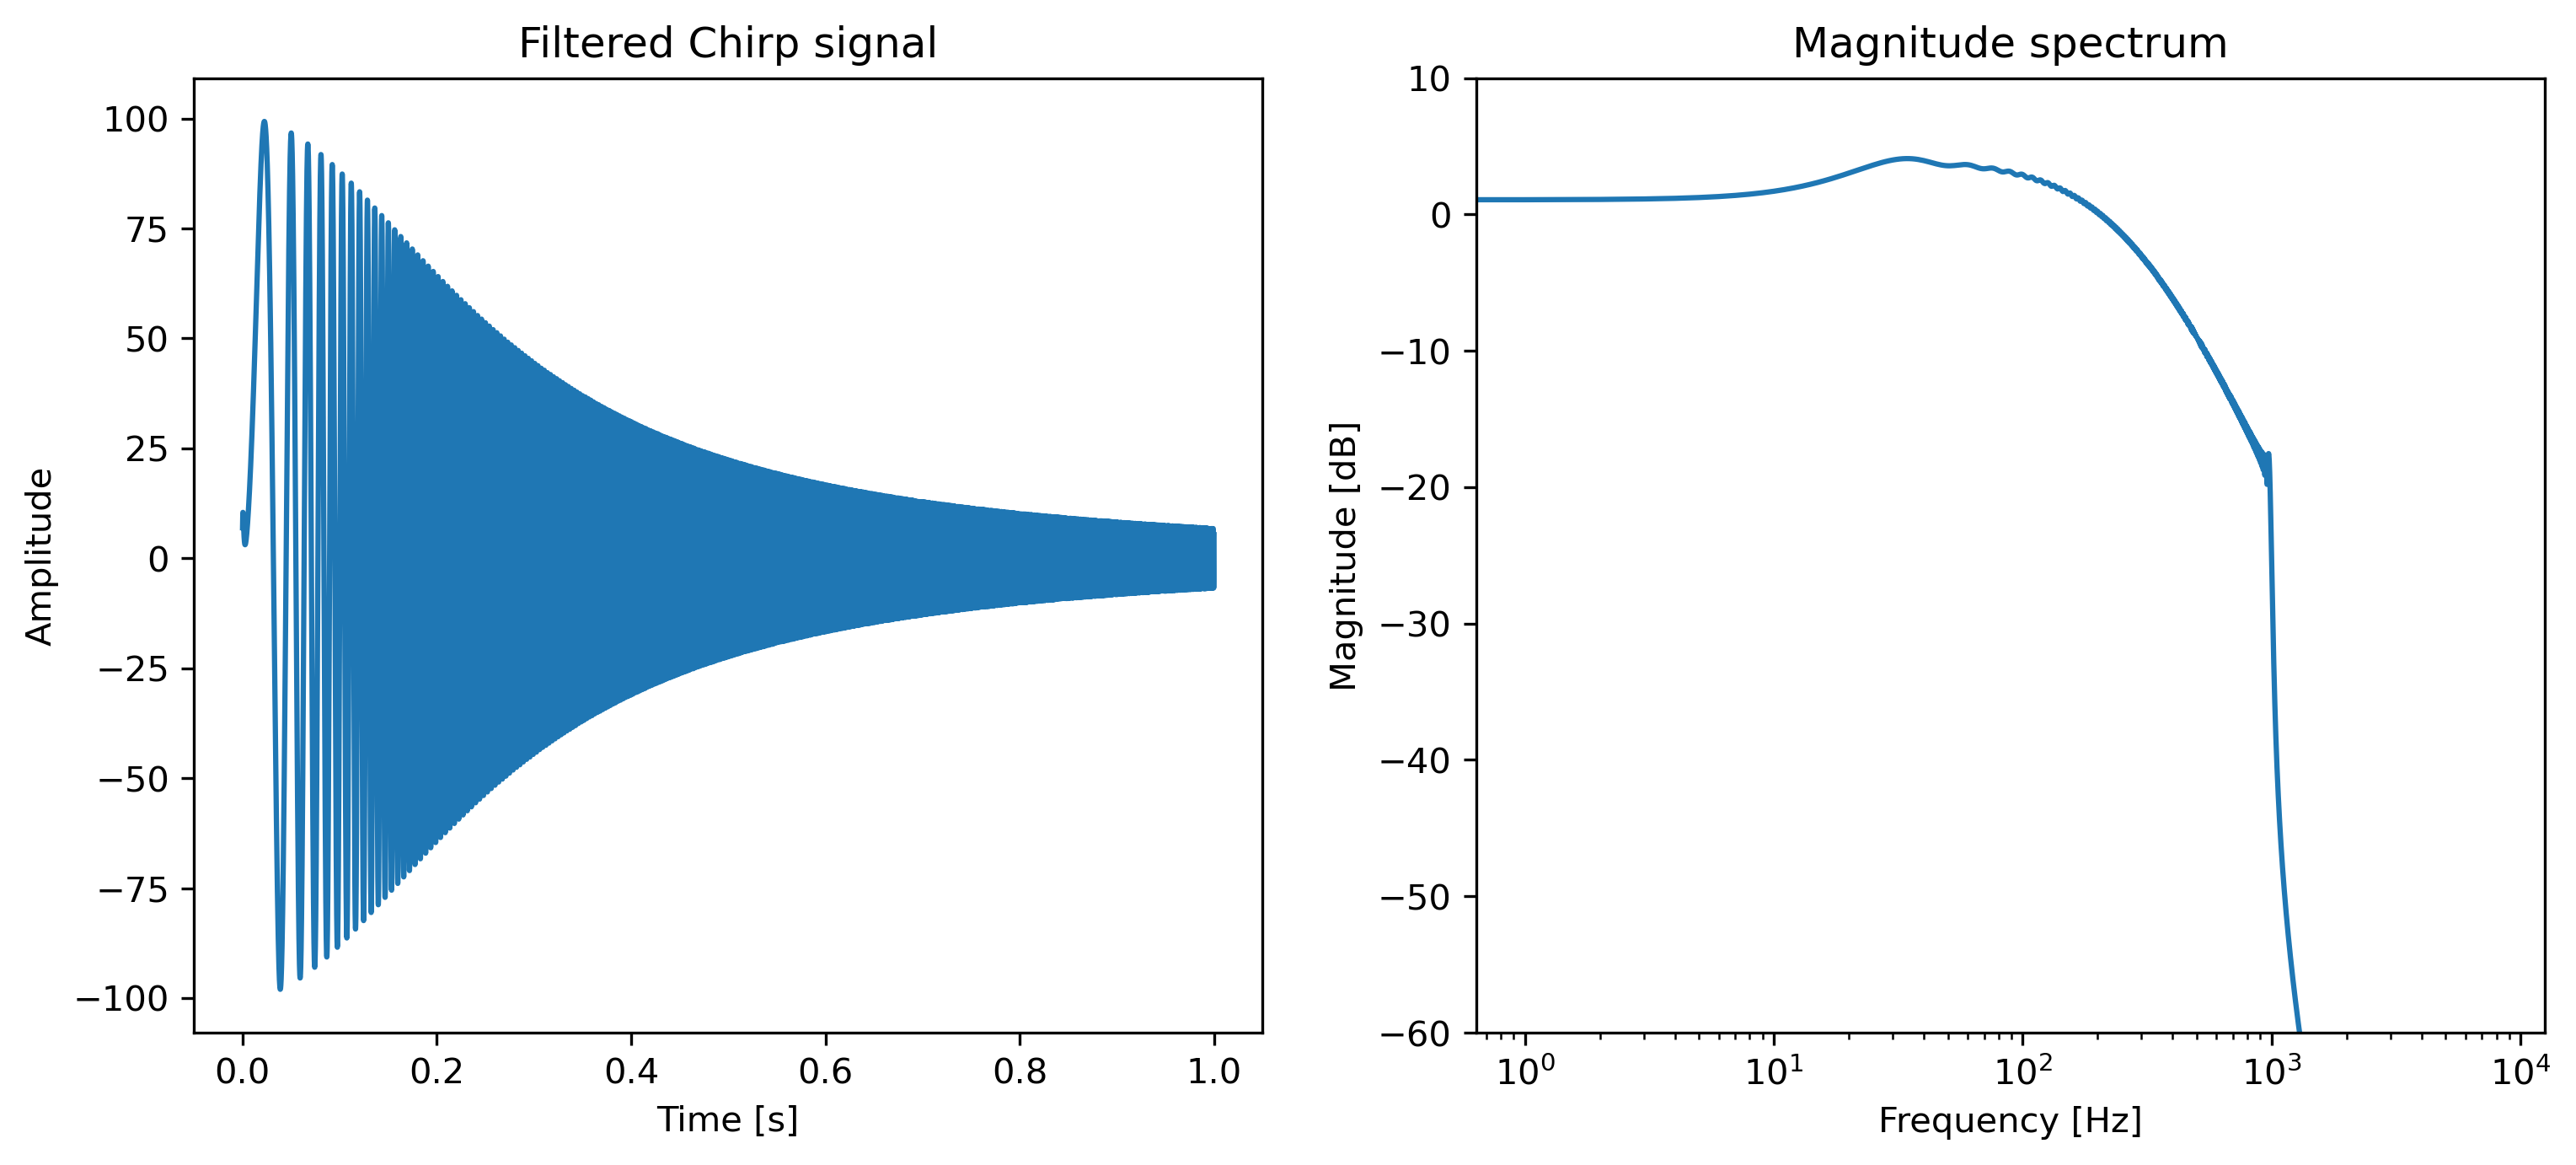

In [191]:
filtered_signal_freq = freq_iir(test_signal_torch, a_torch)

print(f"Is the filtered signal the same? {torch.allclose(filtered_signal_freq, torch.from_numpy(filtered_signal))}")

fig = plt.figure(figsize=(12, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(np.arange(T) / fs, filtered_signal_freq.numpy())
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Filtered Chirp signal")
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(filtered_signal_freq.numpy(), Fs=fs, scale='dB', window=signal.windows.boxcar(T))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.xscale("log")
plt.ylim(-60, 10)
plt.title("Magnitude spectrum")
plt.show()

The above code shows that this approximation does not generate the same output. Although the frequency response looks very close to the original, it does not pass the test. This is because performing the discrete time Fourier transform (DTFT) of IIR system equals sampling the system response on discrete frequencies, thus truncate the infinity impulse response to the same length FFT. Below is the truncated $h_k$ we used in the above example. The sampling process also makes $h_k$ become periodic, so the outputs is actually a circular convolution of the input and $h_k$. This difference is most obvious in our filtered signal at $t \to 0$.

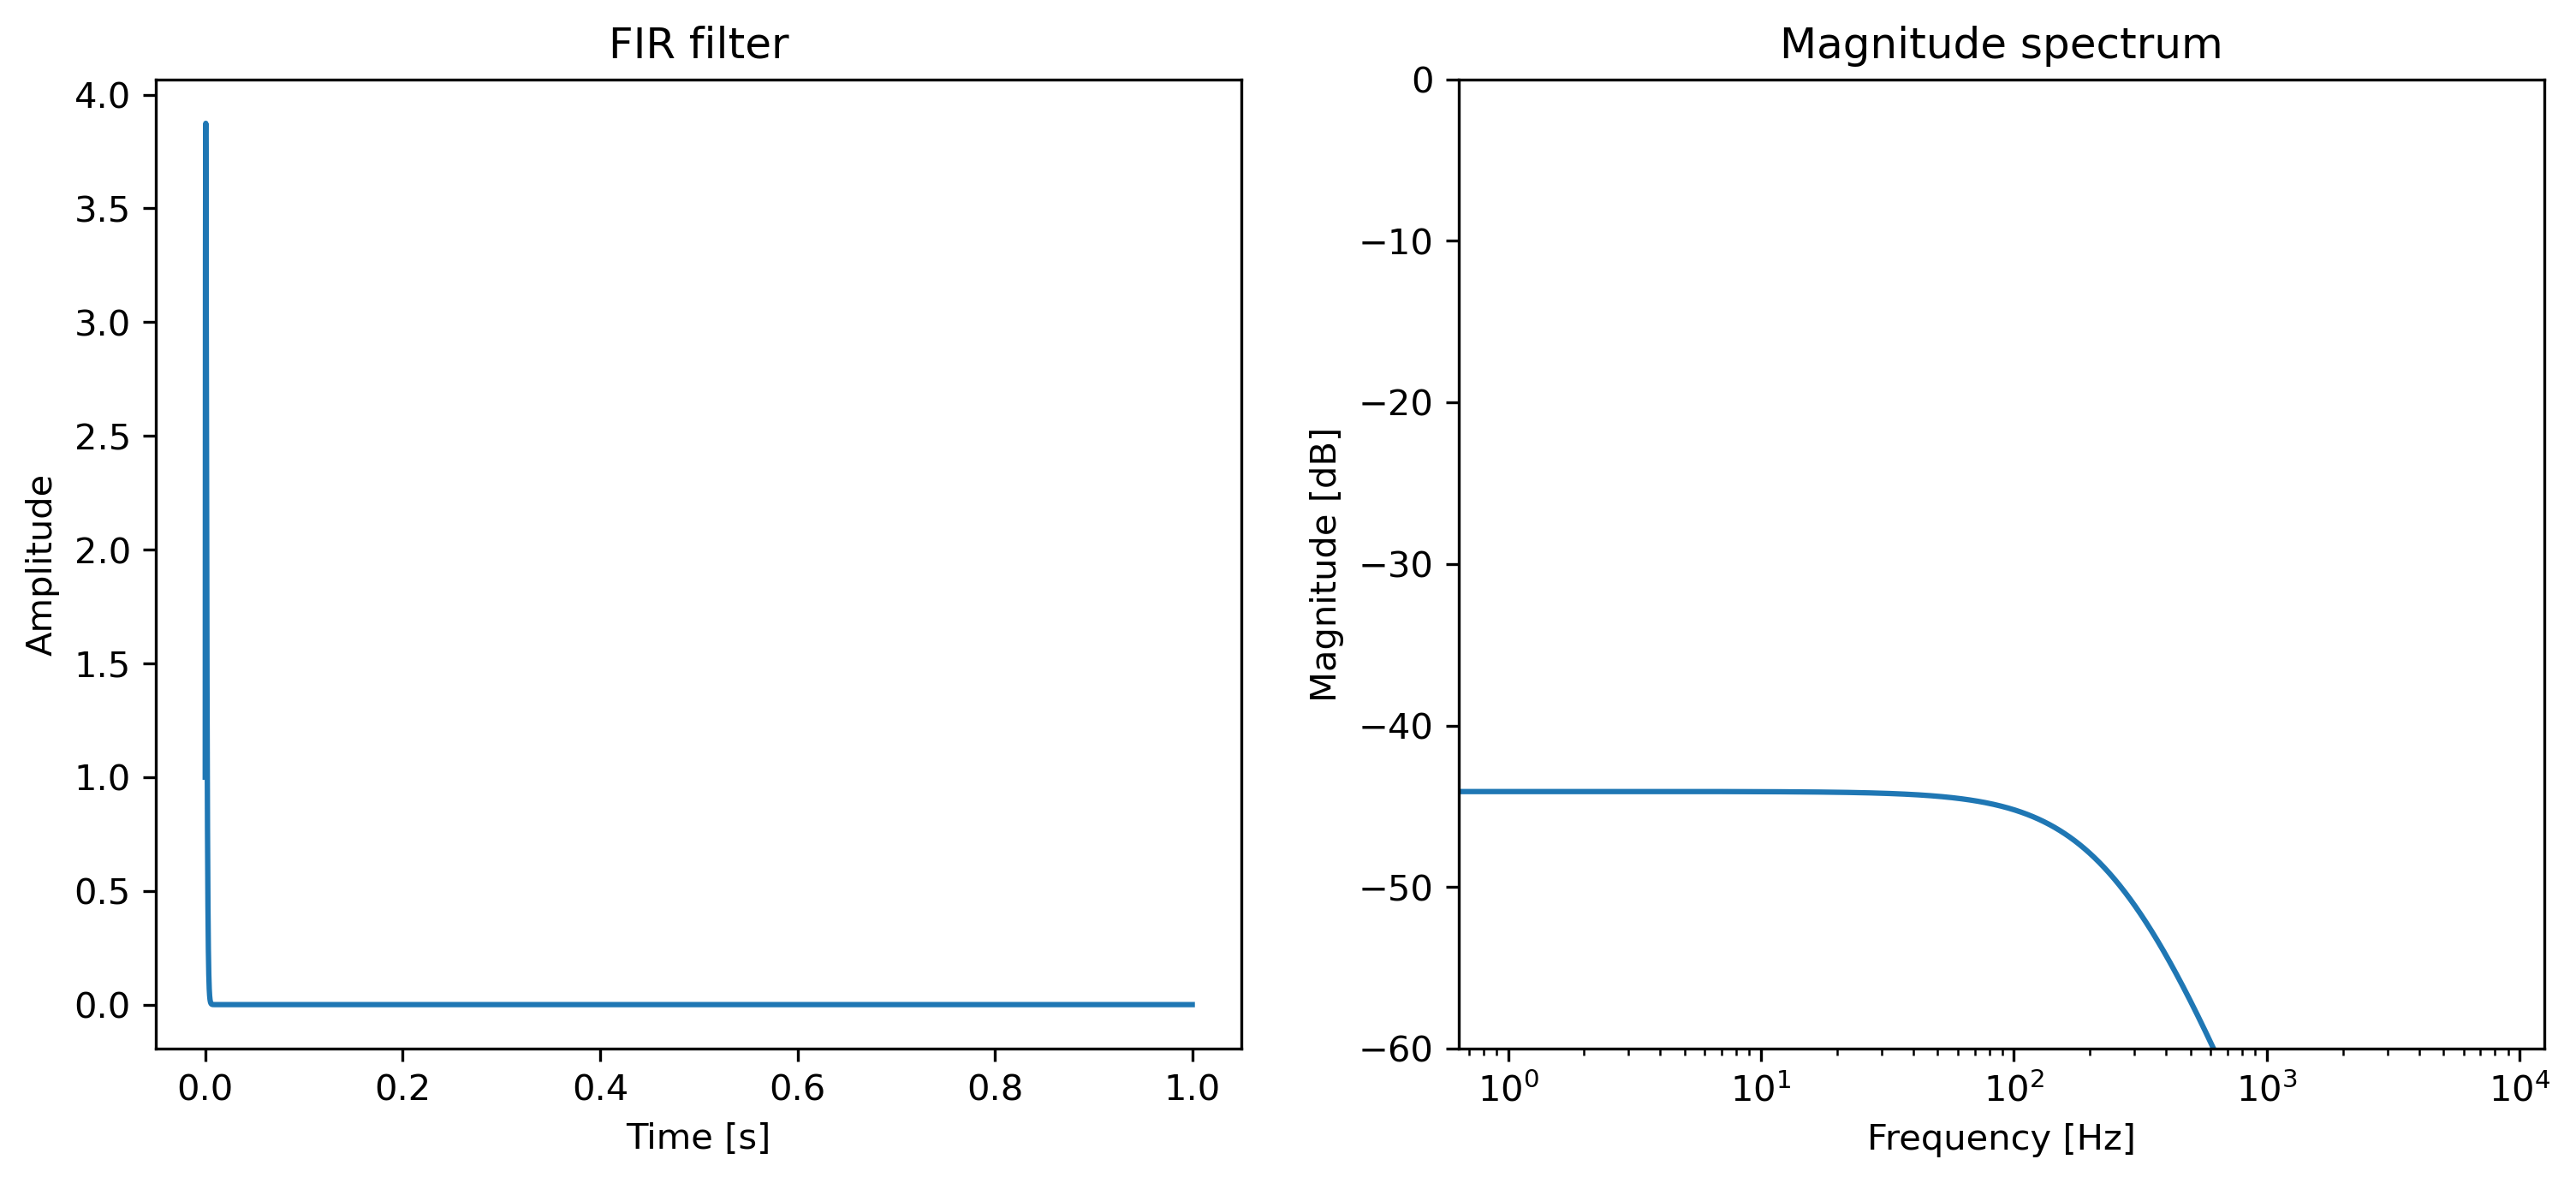

In [192]:
h = get_fir_from_iir(a_torch, T)

fig = plt.figure(figsize=(12, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(np.arange(T) / fs, h.numpy())
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("FIR filter")
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(h.numpy(), Fs=fs, scale='dB', window=signal.windows.boxcar(T))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.xscale("log")
plt.ylim(-60, 0)
plt.title("Magnitude spectrum")
plt.show()

Let us benchmark the performance of this approximation.

In [200]:
torch_time = timeit(
    stmt="iir(test_signal_torch, a_torch)",
    globals={
        "a_torch": a_torch,
        "test_signal_torch": test_signal_torch,
        "iir": freq_iir
    },
    number=100
) / 100

print(f"freq_iir: {torch_time:.4f} [s]")

freq_iir: 0.0013 [s]


Wooosh! It is super duper fast! Although it is still slower than the `scipy.signal.lfilter` function, it is much faster than the direct implementation. In addition, it is differentiable and can be used in gradient-based methods. Moreover, in many cases, we only care about the frequency response of the filter and not its convolution result. You can compute the loss on the transfer function directly without converting it back to the time domain. Although FFT needs more memory than the direct implementation, the gain in speed outweighs the memory cost.

## Summary

## References